### Machine Learning in Finance
- Sheida Majidi

In [72]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.model_selection import TimeSeriesSplit
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import scipy.linalg as sla
import scipy.sparse.linalg as ssla
import copy
from datetime import datetime
from timeit import default_timer as timer
from scipy.linalg import lstsq


In [3]:
factors_char_list = pd.read_csv('/Users/sheidamajidi/Desktop/Summer2024/FINE695/HW1/data/factors_char_list.csv')
sample_big = pd.read_csv('/Users/sheidamajidi/Desktop/Summer2024/FINE695/HW1/data/homework_sample_big.csv')

### Data preprocessing

In [5]:
missing_values = sample_big.isnull().sum()
print("Missing values per column:\n", missing_values)

Missing values per column:
 date              0
ret_eom           0
permno            0
stock_ret         0
mspread           0
               ... 
qmj_prof         17
qmj_growth     7653
qmj_safety        3
rf                0
stock_exret       0
Length: 159, dtype: int64


In [47]:
# handle missing values (approach: weighted bagging imputation)

def simple_bagging_impute(model, X_train, y_train, X_missing, n_iter=50, random_state=1234):
    rng = np.random.RandomState(random_state)
    n = X_train.shape[0]
    index = list(range(n))
    
    predictions = np.zeros((n_iter, X_missing.shape[0]))
    
    for i in range(n_iter):
        # resample the data
        resample_ind = rng.choice(index, size=n, replace=True)
        x_train_resampled = X_train[resample_ind]
        y_train_resampled = y_train[resample_ind]

        # fit the model with resampled data
        model.fit(x_train_resampled, y_train_resampled)

        # predict missing values
        predictions[i] = model.predict(X_missing)
    
    return predictions.mean(axis=0)

# handle missing values - bagging approach
def fill_missing_values_with_bagging(data, columns, factors_char_list, n_iter=50):
    filled_data = data.copy()
    
    # imputer for predictors
    imputer = SimpleImputer(strategy='mean')

    for column in columns:
        missing_indices = filled_data[column].isnull()
        if missing_indices.any():

            X_train = filled_data.loc[~missing_indices, factors_char_list['variable']]
            X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)

            y_train = filled_data.loc[~missing_indices, column].values

            X_missing = filled_data.loc[missing_indices, factors_char_list['variable']]
            X_missing = pd.DataFrame(imputer.transform(X_missing), columns=X_missing.columns)

            y_pred = simple_bagging_impute(LinearRegression(), X_train.values, y_train, X_missing.values, n_iter=n_iter)
            filled_data.loc[missing_indices, column] = y_pred
    
    return filled_data


In [48]:
sample_big_filled = fill_missing_values_with_bagging(sample_big, sample_big.columns, factors_char_list)
print(sample_big_filled.isnull().sum())

date           0
ret_eom        0
permno         0
stock_ret      0
mspread        0
              ..
qmj_prof       0
qmj_growth     0
qmj_safety     0
rf             0
stock_exret    0
Length: 159, dtype: int64


In [94]:
sample_big_filled.to_csv('/Users/sheidamajidi/Desktop/Summer2024/FINE695/HW1/data/homework_sample_big_filled.csv', index=False)

### Exploratory Data Analysis

In [58]:
# 1. statistical summary
sample_big_filled.describe()

,date,ret_eom,permno,stock_ret,mspread,year,month,me,prc,market_equity,...,corr_1260d,betabab_1260d,rmax5_rvol_21d,age,qmj,qmj_prof,qmj_growth,qmj_safety,rf,stock_exret
count,1.124100e+05,1.124100e+05,112410.000000,112410.000000,112410.000000,112410.000000,112410.000000,1.124100e+05,112410.000000,1.124100e+05,...,112410.000000,112410.000000,112410.000000,112410.000000,112410.000000,112410.000000,112410.000000,112410.000000,112410.000000,112410.000000
mean,2.014174e+07,2.014174e+07,56983.925692,0.009054,0.007201,2014.106254,6.499226,2.612385e+04,103.504869,2.612385e+04,...,0.556570,1.131160,1.192330,416.302900,0.404592,0.659548,0.148896,0.114674,0.001138,0.007916
std,5.518660e+04,5.518662e+04,29994.829504,0.107867,0.004670,5.518370,3.458947,8.835090e+04,1289.229845,8.835090e+04,...,0.129102,0.436150,0.487992,277.712836,0.920880,0.878861,0.925060,0.851327,0.001457,0.107907
min,2.005013e+07,2.005013e+07,10078.000000,-0.880435,0.000332,2005.000000,1.000000,5.662170e+01,0.420000,5.662170e+01,...,-0.027610,-0.069198,0.030556,30.000000,-1.731312,-1.719048,-1.725835,-1.722088,0.000000,-0.880435
25%,2.009103e+07,2.009103e+07,23393.000000,-0.044446,0.004355,2009.000000,3.000000,4.072313e+03,30.809999,4.072313e+03,...,0.476246,0.837555,0.856127,193.000000,-0.281948,0.086066,-0.611525,-0.548175,0.000000,-0.045716
50%,2.014093e+07,2.014093e+07,65875.000000,0.009628,0.005987,2014.000000,6.000000,7.733556e+03,52.090000,7.733556e+03,...,0.558044,1.104598,1.111998,330.000000,0.431967,0.900003,0.148896,0.132588,0.000200,0.008458
75%,2.019063e+07,2.019063e+07,85067.000000,0.062202,0.008526,2019.000000,10.000000,1.908786e+04,87.407503,1.908786e+04,...,0.648890,1.359462,1.433099,609.000000,1.222850,1.399454,0.959372,0.797010,0.001900,0.061129
max,2.023123e+07,2.023123e+07,93436.000000,2.135168,0.084777,2023.000000,12.000000,3.071345e+06,134650.000000,3.071345e+06,...,0.881086,5.076313,4.562260,1175.000000,1.731424,1.731506,1.730077,1.731361,0.004700,2.135168


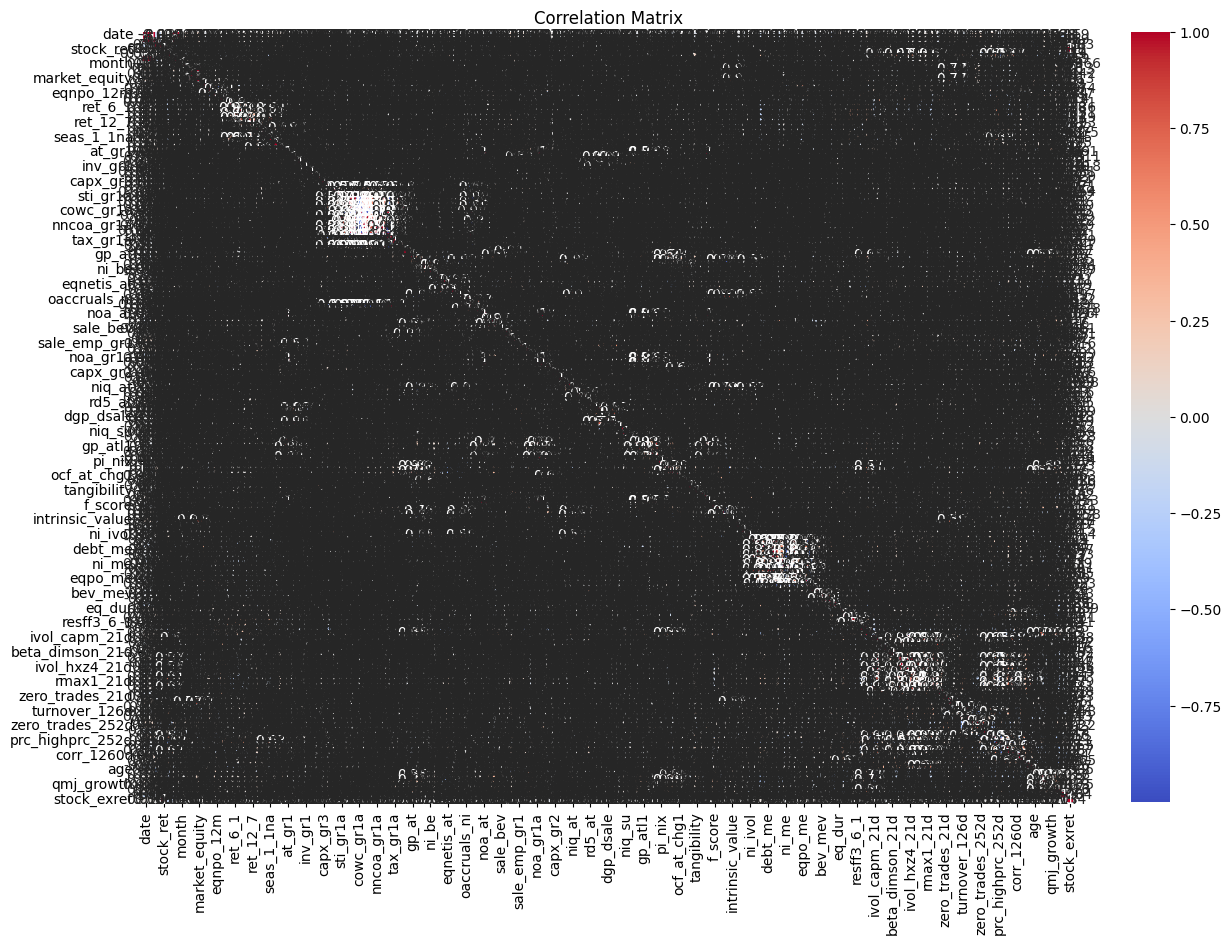

In [53]:
# 2. correlation matrix

numeric_columns = sample_big_filled.select_dtypes(include=[np.number]).columns
correlation_matrix = sample_big_filled[numeric_columns].corr()

plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

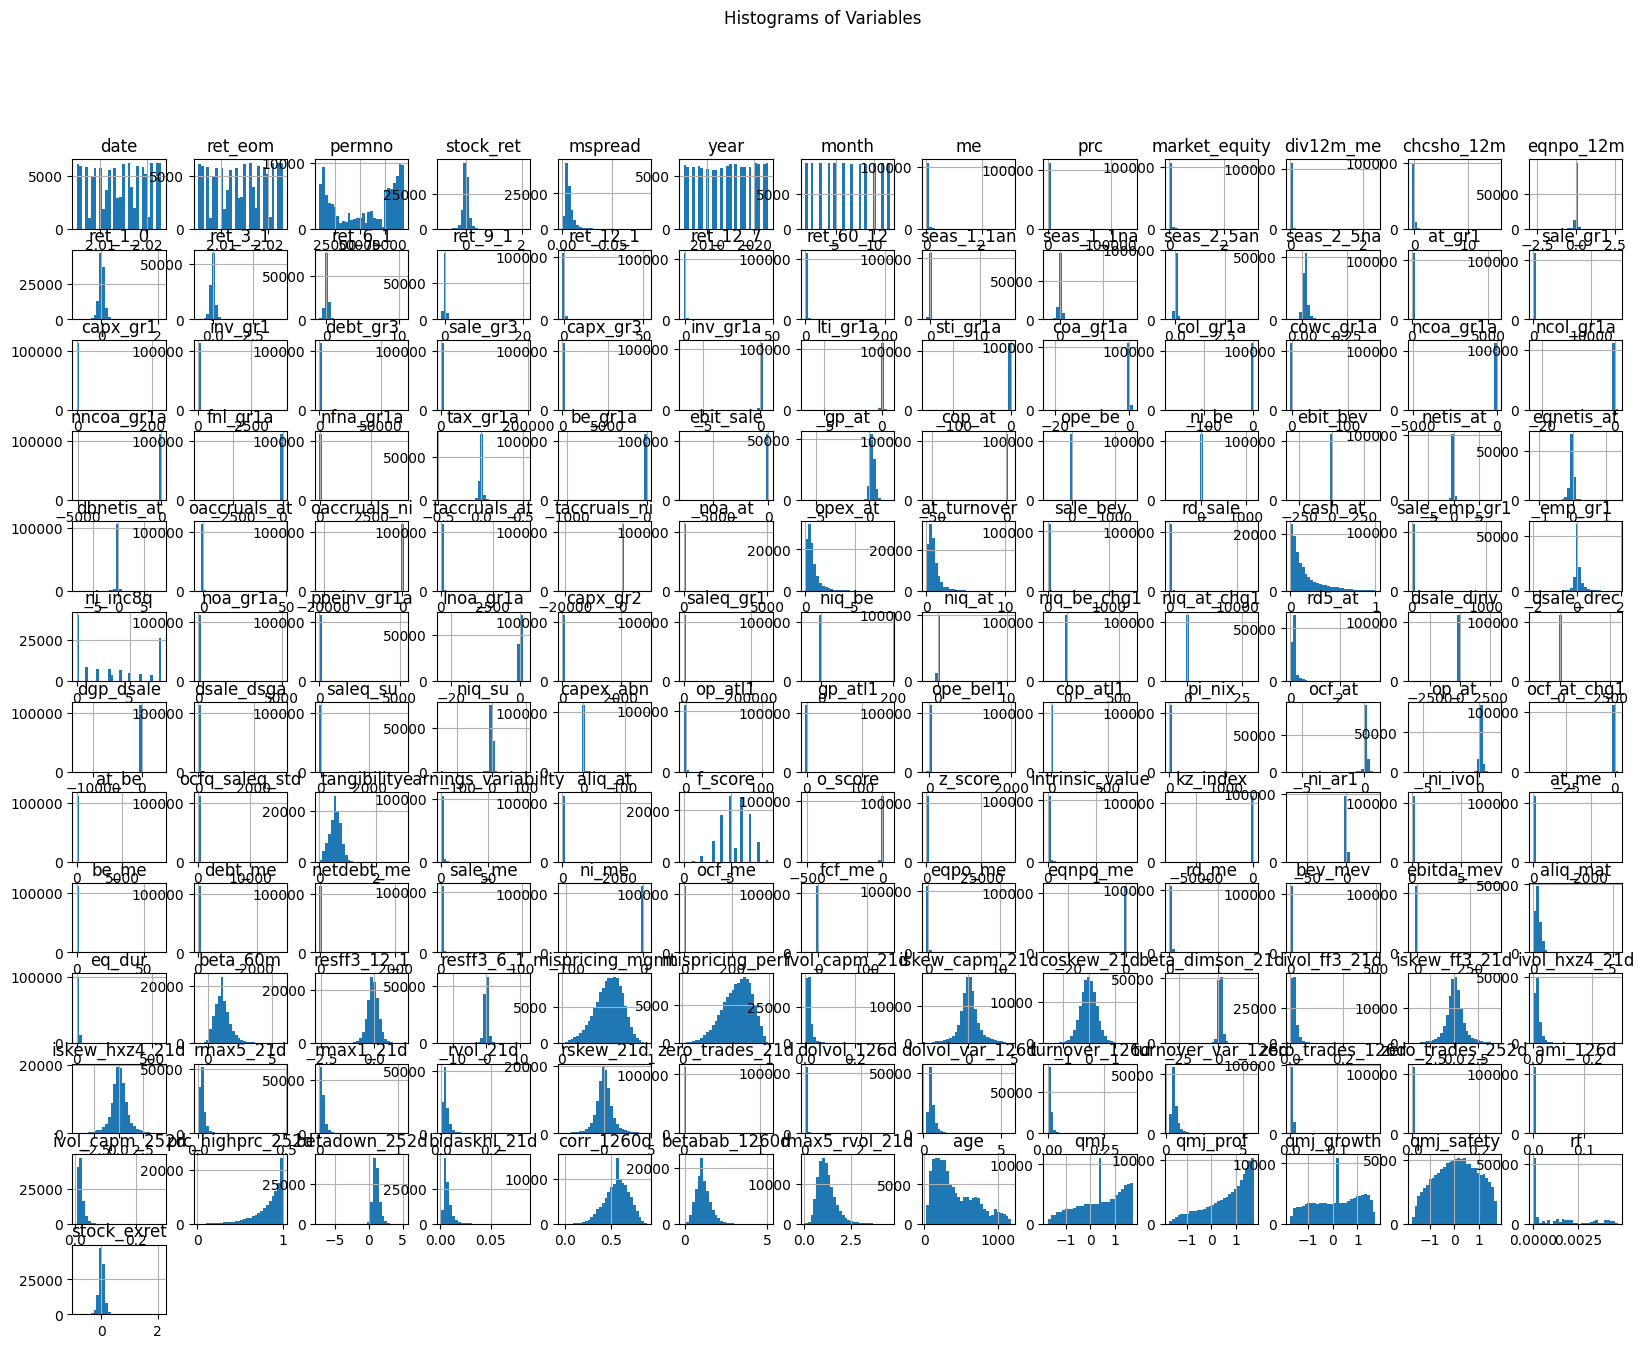

In [54]:
# 3. Histograms plots
sample_big_filled.hist(bins=30, figsize=(20, 15))
plt.suptitle('Histograms of Variables')
plt.show()

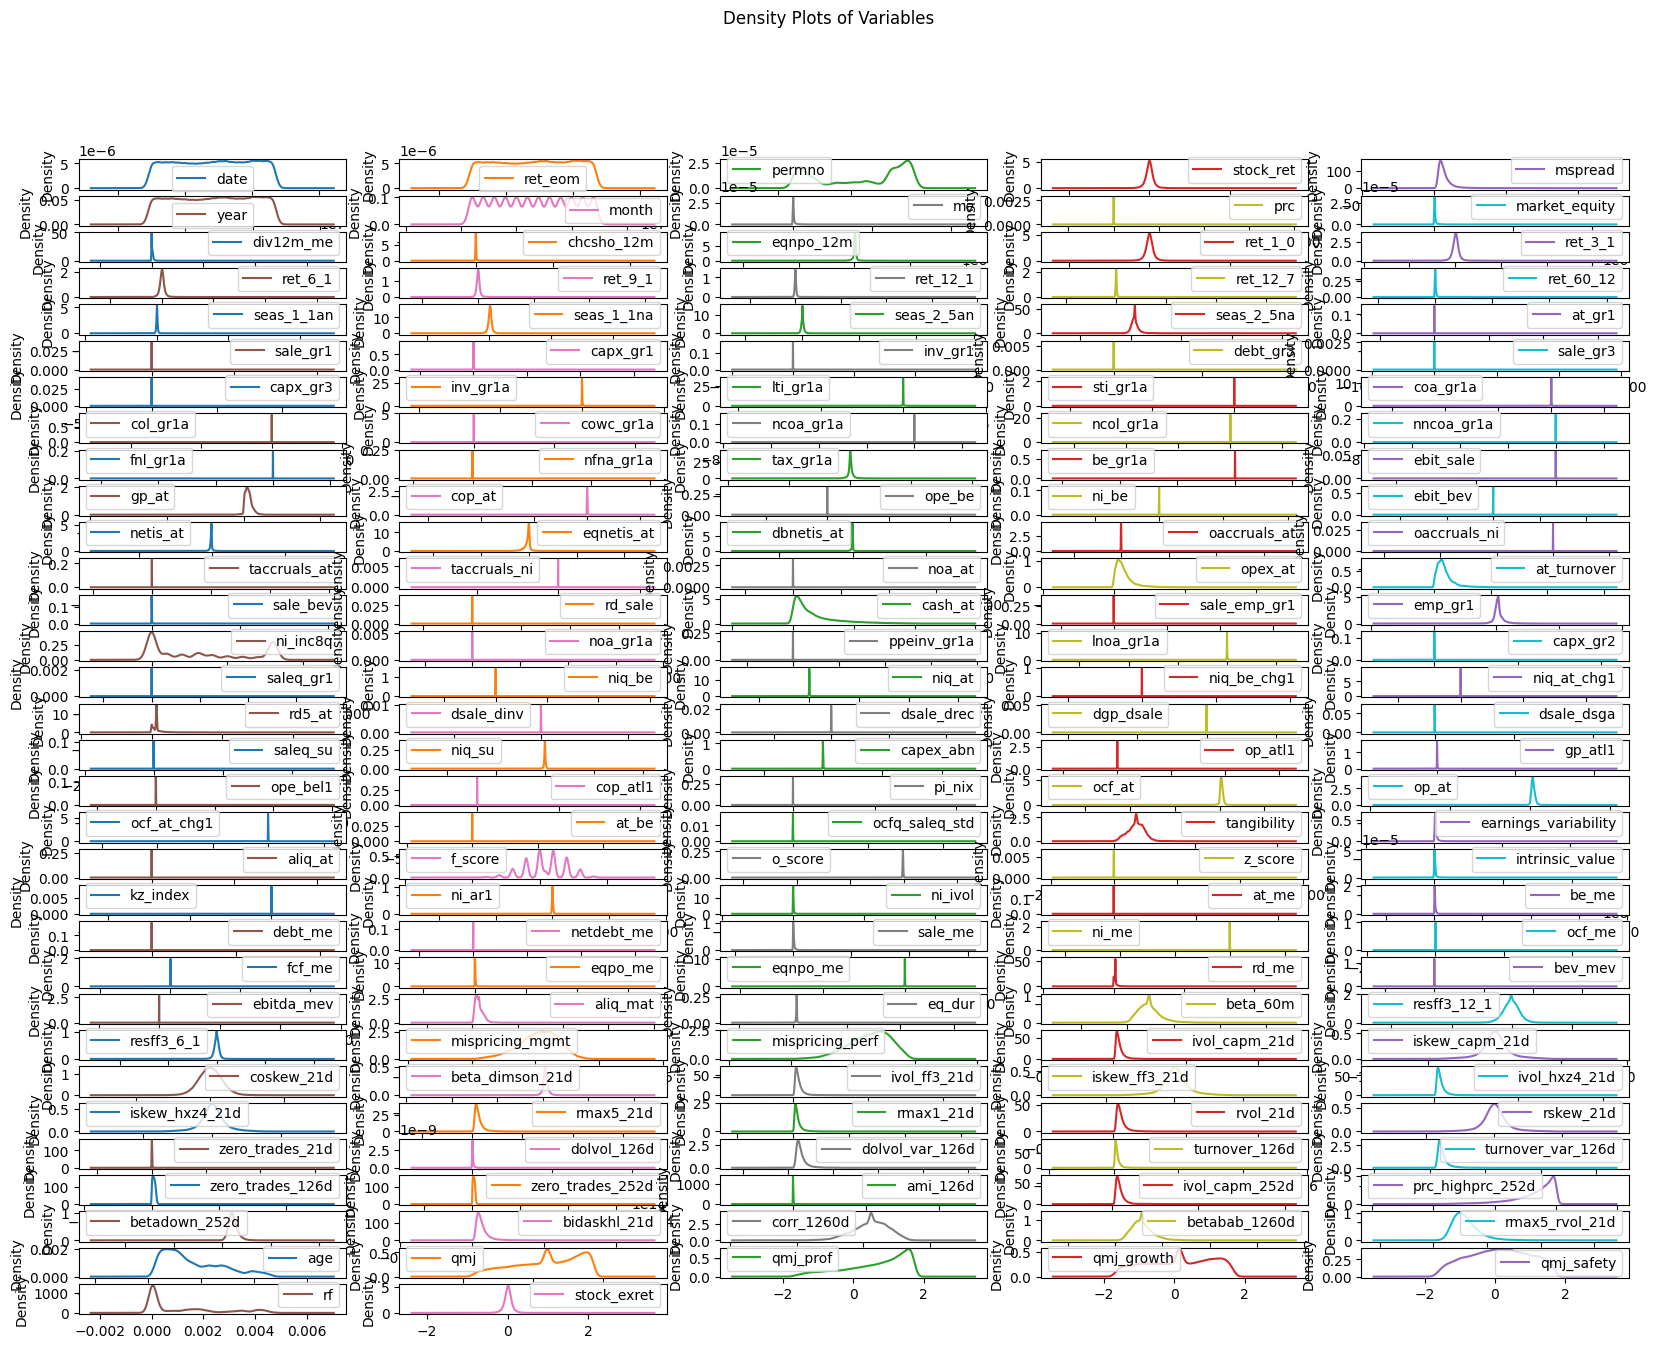

In [59]:
# 4. Density plots (only for numeric columns)
num_plots = len(numeric_columns)
cols = 5
rows = num_plots // cols + (num_plots % cols > 0)

sample_big_filled[numeric_columns].plot(kind='density', subplots=True, layout=(rows, cols), sharex=False, figsize=(20, 15))
plt.suptitle('Density Plots of Variables')
plt.show()

In [65]:
# 5. binomial table
binom_table = pd.crosstab(sample_big_filled['sizeport'], sample_big_filled['roeport'])
print(binom_table)

chi2, p, dof, expected = chi2_contingency(binom_table)
print(f'Chi-Square Test: chi2={chi2}, p-value={p}')

roeport       P      V
sizeport              
B         73168  39242
Chi-Square Test: chi2=0.0, p-value=1.0


In [64]:
multi_table = pd.crosstab([sample_big_filled['sizeport'], sample_big_filled['roeport']], sample_big_filled['month'])
print(multi_table)

chi2, p, dof, expected = chi2_contingency(multi_table)
print(f'Multinomial Chi-Square Test: chi2={chi2}, p-value={p}')

month               1     2     3     4     5     6     7     8     9     10  \
sizeport roeport                                                               
B        P        5986  6002  6029  6157  6162  6088  6041  6047  6054  6191   
         V        3424  3390  3385  3214  3205  3235  3247  3243  3248  3206   

month               11    12  
sizeport roeport              
B        P        6189  6222  
         V        3222  3223  
Multinomial Chi-Square Test: chi2=30.146895714599594, p-value=0.0015025616814257137


### Modeling analysis

In [118]:
class IPCA:
    def __init__(self, RZ, return_column='stock_exret', add_constant=True):
        self.RZ = RZ
        self.return_column = return_column
        self.add_constant = add_constant
        
        numeric_columns = RZ.drop(columns=[return_column]).select_dtypes(include=[np.number]).columns
        self._X = RZ[numeric_columns].astype(np.float32).values.T
        self._R = RZ[return_column].astype(np.float32).values.T
        self.L = self._X.shape[0]  # number of characteristics
        self.T = self._X.shape[1]  # number of time periods
        
        self.Chars = numeric_columns
        self.Dates = RZ.index.get_level_values(0).unique()
        self._W = np.ones((self.L, self.T), dtype=np.float32)  # W is float

    def fit(self, K=1, OOS=False, normalization_choice="PCA_positivemean", normalization_choice_specs=None, 
            minTol=1e-4, maxIters=5000, F_names=None, G_names=None, R2_bench='zero', 
            R_fit=True, Beta_fit=False, dispIters=False, dispItersInt=100):
        
        if F_names is None:
            F_names = ["F" + str(i + 1) for i in range(K)]
        self.F_names = F_names

        if R2_bench not in ["zero", "mean"]:
            raise ValueError("R2_bench must be 'zero' or 'mean'")
        self.R2_bench = R2_bench

        if G_names is None:
            G_names = list(self.Chars)
        self.G_names = G_names

        self._normalize_chars(normalization_choice, normalization_choice_specs)

        L, T = self.L, self.T
        X = self._X
        W = self._W

        Gamma = np.random.randn(L, K).astype(np.float32)
        F = np.zeros((K, T), dtype=np.float32)

        prev_loss = np.inf
        converged = False

        for iter_num in range(1, maxIters + 1):
            start_time = timer()

            for t in range(T):
                F[:, t] = lstsq(Gamma.T.dot(np.diag(W[:, t])).dot(Gamma), Gamma.T.dot(X[:, t]))[0]

            for l in range(L):
                Gamma[l, :] = lstsq(F.dot(np.diag(W[l, :])).dot(F.T), F.dot(X[l, :].T))[0]

            loss = 0.0
            for t in range(T):
                loss += np.sum((X[:, t] - Gamma.dot(F[:, t]))**2)

            if abs(prev_loss - loss) < minTol:
                converged = True
                break
            prev_loss = loss

            if dispIters and iter_num % dispItersInt == 0:
                print(f"Iteration {iter_num}, Loss: {loss:.4e}, Time: {timer() - start_time:.4f}s")

        if not converged:
            print("Warning: Optimization did not converge. Try increasing maxIters or adjusting minTol.")

        self.Gamma, self.F = Gamma, F

        if R_fit:
            self._fit_returns()

        if Beta_fit:
            self._fit_betas()

        print(f"Fit complete: {iter_num} iterations, Loss: {loss:.4e}")

        results = {
            'Gamma': self.Gamma,
            'Factor': self.F,
            'Lambda': self.betas if Beta_fit else None,
            'xfits': self.fitted_returns if R_fit else None,
            'rfits': self.fitted_returns if R_fit else None,
            'fittedBeta': self.betas if Beta_fit else None
        }

        return results

    def _normalize_chars(self, normalization_choice, normalization_choice_specs):
        if normalization_choice == "PCA_positivemean":
            Gamma = np.eye(self.L)
            self.Gamma = Gamma
        elif normalization_choice == "Identity":
            if normalization_choice_specs is None:
                raise ValueError("Normalization choice 'Identity' requires specs.")
            char_indices = [self.Chars.get_loc(char) for char in normalization_choice_specs]
            Gamma = np.zeros((self.L, len(char_indices)))
            for i, idx in enumerate(char_indices):
                Gamma[idx, i] = 1
            self.Gamma = Gamma
        else:
            raise ValueError("Unknown normalization choice.")

    def _fit_returns(self):
        fitted_returns = np.zeros_like(self._R)
        for t in range(len(self.Dates)):
            fitted_returns[:, t] = self.Gamma.dot(self.F[:, t])
        self.fitted_returns = pd.DataFrame(fitted_returns.T, index=self.Dates, columns=self.Chars)

    def _fit_betas(self):
        betas = np.zeros_like(self._X)
        for t in range(len(self.Dates)):
            betas[:, t] = lstsq(self.Gamma, self._X[:, t])[0]
        self.betas = pd.DataFrame(betas.T, index=self.Dates, columns=self.Chars)

    def predict(self, new_data):
        if not isinstance(new_data, pd.DataFrame):
            raise ValueError("new_data should be a pandas DataFrame.")

        new_dates = new_data.index.get_level_values(0).unique()
        predicted_returns = np.zeros((self.L, len(new_dates)))

        for i, date in enumerate(new_dates):
            Zt = new_data.loc[date, :].values
            if self.add_constant:
                Zt = np.concatenate((Zt, np.ones((Zt.shape[0], 1))), axis=1)
            predicted_returns[:, i] = self.Gamma.dot(Zt.T)

        return pd.DataFrame(predicted_returns, index=self.Chars, columns=new_dates)

    def score(self, actual_data, benchmark="mean"):
        if not isinstance(actual_data, pd.DataFrame):
            raise ValueError("actual_data should be a pandas DataFrame.")

        actual_returns = actual_data.values
        fitted_returns = self.fitted_returns.values

        if benchmark == "mean":
            mean_return = np.mean(actual_returns, axis=1)
            ss_total = np.sum((actual_returns - mean_return[:, None])**2)
        elif benchmark == "zero":
            ss_total = np.sum(actual_returns**2)
        else:
            raise ValueError("Unknown benchmark for R-squared calculation.")

        ss_residual = np.sum((actual_returns - fitted_returns)**2)
        R2 = 1 - (ss_residual / ss_total)

        return R2


In [119]:
# initialize IPCA model
ipca_model = IPCA(RZ=sample_big_filled, return_column='stock_exret', add_constant=True)

In [ ]:
# fit the model
results = ipca_model.fit(K=3, OOS=False, R_fit=True, Beta_fit=True, dispIters=True)

In [ ]:
# results
Gamma = results['Gamma']
Factor = results['Factor']
Lambda = results['Lambda']
fittedX = results['xfits']
fittedR = results['rfits']
fittedBeta = results['fittedBeta']

print("Gamma (Characteristic Loadings):\n", Gamma)
print("Factor (Factors):\n", Factor)
print("Lambda (Lambda):\n", Lambda)
print("Fitted X (Fitted Characteristics):\n", fittedX)
print("Fitted R (Fitted Returns):\n", fittedR)
print("Fitted Beta (Betas):\n", fittedBeta)

In [172]:
class IPCA:
    def __init__(self, RZ, return_column='stock_exret', add_constant=True):
        self.RZ = RZ
        self.return_column = return_column
        self.add_constant = add_constant

        # the data is sorted by date
        self.RZ = self.RZ.sort_values(by='date')

        if 'date' in self.RZ.index.names:
            self.RZ = self.RZ.reset_index()

        numeric_columns = self.RZ.drop(columns=[return_column, 'date']).select_dtypes(include=[np.number]).columns
        self._X = self.RZ[numeric_columns].astype(np.float32).values.T
        self._R = self.RZ[return_column].astype(np.float32).values.T
        self.L = self._X.shape[0]  # Number of characteristics
        self.T = self._X.shape[1]  # Number of time periods

        self.Chars = numeric_columns
        self.Dates = pd.to_datetime(self.RZ['date'].unique())
        self._W = np.ones((self.L, self.T), dtype=np.float32)  # W is float

        print(f"Initialized IPCA with {self.L} characteristics and {self.T} time periods")
        print(f"Dates length: {len(self.Dates)}, Dates: {self.Dates}")

    def fit(self, K, maxIters=1000, minTol=1e-6, dispIters=False, dispItersInt=10):
        L, T = self.L, self.T
        Gamma = np.random.randn(L, K).astype(np.float32)
        F = np.zeros((K, T), dtype=np.float32)
        W = self._W
        X = self._X

        prev_loss = np.inf
        start_time = timer()

        for iter_num in range(1, maxIters + 1):
            for t in range(T):
                F[:, t] = lstsq(Gamma.T.dot(np.diag(W[:, t])).dot(Gamma), Gamma.T.dot(X[:, t]))[0]

            for l in range(L):
                Gamma[l, :] = lstsq(F.dot(np.diag(W[l, :])).dot(F.T), F.dot(X[l, :].T))[0]

            loss = np.sum((X - Gamma @ F)**2)

            if dispIters and iter_num % dispItersInt == 0:
                elapsed_time = timer() - start_time
                print(f"Iteration {iter_num}, Loss: {loss:.4e}, Time: {elapsed_time:.4f}s")

            if abs(prev_loss - loss) < minTol:
                break

            prev_loss = loss

        if iter_num == maxIters:
            print("Warning: Optimization did not converge. Try increasing maxIters or adjusting minTol.")

        self.Gamma, self.F = Gamma, F
        self._fit_returns()
        print(f"Fit complete: {iter_num} iterations, Loss: {loss:.4e}")

        results = {
            'Gamma': self.Gamma,
            'Factor': self.F,
            'Lambda': np.linalg.lstsq(self.F.T, self._R.T, rcond=None)[0].T,
            'xfits': self.Gamma @ self.F,
            'rfits': self.F.T @ np.linalg.lstsq(self.F.T, self._R.T, rcond=None)[0].T,
            'fittedBeta': self.Gamma
        }

        return results

    def _fit_returns(self):
        fitted_returns = self.Gamma @ self.F
        print(f"Shape of fitted_returns: {fitted_returns.shape}")
        print(f"Shape of self.Dates: {len(self.Dates)}, Shape of self.Chars: {len(self.Chars)}")
        
        if len(self.Dates) < self.T:
            factor = self.T // len(self.Dates) + 1
            extended_dates = np.tile(self.Dates, factor)[:self.T]
            self.Dates = pd.to_datetime(extended_dates)
        elif len(self.Dates) > self.T:
            self.Dates = self.Dates[:self.T]

        self.fitted_returns = pd.DataFrame(fitted_returns.T, index=self.Dates, columns=self.Chars)
        print(f"Shape of self.fitted_returns: {self.fitted_returns.shape}")


In [173]:
# sample 60 stocks from the data (for faster computation)
sample_stocks = sample_big_filled['permno'].unique()
np.random.seed(42)  # for reproducibility
selected_stocks = np.random.choice(sample_stocks, 60, replace=False)
sample_data = sample_big_filled[sample_big_filled['permno'].isin(selected_stocks)]

sample_data = sample_data.reset_index()  # reset index to handle 'date' correctly
sample_data = sample_data.set_index('date')

# initialize the IPCA model
ipca_model = IPCA(RZ=sample_data, return_column='stock_exret', add_constant=True)


Initialized IPCA with 156 characteristics and 3377 time periods
Dates length: 228, Dates: <DatetimeArray>
['1970-01-01 00:00:00.020050131', '1970-01-01 00:00:00.020050228',
 '1970-01-01 00:00:00.020050331', '1970-01-01 00:00:00.020050429',
 '1970-01-01 00:00:00.020050531', '1970-01-01 00:00:00.020050630',
 '1970-01-01 00:00:00.020050729', '1970-01-01 00:00:00.020050831',
 '1970-01-01 00:00:00.020050930', '1970-01-01 00:00:00.020051031',
 ...
 '1970-01-01 00:00:00.020230331', '1970-01-01 00:00:00.020230428',
 '1970-01-01 00:00:00.020230531', '1970-01-01 00:00:00.020230630',
 '1970-01-01 00:00:00.020230731', '1970-01-01 00:00:00.020230831',
 '1970-01-01 00:00:00.020230929', '1970-01-01 00:00:00.020231031',
 '1970-01-01 00:00:00.020231130', '1970-01-01 00:00:00.020231229']
Length: 228, dtype: datetime64[ns]


In [174]:
#  fit the model
results = ipca_model.fit(K=3, dispIters=True, dispItersInt=10, maxIters=100)


Shape of fitted_returns: (156, 3377)
Shape of self.Dates: 228, Shape of self.Chars: 156
Shape of self.fitted_returns: (3377, 156)
Fit complete: 7 iterations, Loss: 9.0965e+12


In [201]:
# the results
Gamma = results['Gamma']
Factor = results['Factor']
Lambda = results['Lambda']
fittedX = results['xfits']
fittedR = results['rfits']
fittedBeta = results['fittedBeta']

print("Gamma (Characteristic Loadings):\n", Gamma)
print("Factor (Factors):\n", Factor)
print("Lambda (Lambda):\n", Lambda)
print("Fitted X (Fitted Characteristics):\n", fittedX)
print("Fitted R (Fitted Returns):\n", fittedR)
print("Fitted Beta (Betas):\n", fittedBeta)

Gamma (Characteristic Loadings):
 [[-1.57457474e-03  4.93189320e-03 -2.32831948e-03]
 [-5.70519120e-02  1.78900570e-01 -8.41285735e-02]
 [-2.00504131e+01  6.35006409e+01 -2.88402081e+01]
 [-5.75254671e-02  1.83112249e-01 -8.16720501e-02]
 [-1.00780344e-08  3.23823564e-08 -1.39583864e-08]
 [-7.27614857e-09  2.30986288e-08 -1.04025970e-08]
 [-2.00497382e-03  6.34984998e-03 -2.88392371e-03]
 [-6.37840549e-06  2.02093179e-05 -9.16465251e-06]
 [ 1.14654889e-02 -5.08816764e-02 -3.65881424e-04]
 [-8.97933060e-05  2.83773144e-04 -1.29859138e-04]
 [ 1.14654889e-02 -5.08816764e-02 -3.65881424e-04]
 [-1.47756891e-08  4.49376287e-08 -2.34025119e-08]
 [ 6.07031891e-09 -2.58544635e-08  1.06103548e-09]
 [-2.54092409e-08  8.39025702e-08 -3.25793899e-08]
 [-1.02136211e-08  3.26878471e-08 -1.42967949e-08]
 [-2.14487006e-08  6.75483776e-08 -3.12919610e-08]
 [-5.72787187e-08  1.79424802e-07 -8.46793782e-08]
 [-1.00366591e-07  3.13090936e-07 -1.49890468e-07]
 [-1.59126444e-07  4.99025987e-07 -2.34595120e-0

### Analyzing Gamma and Factor

In [202]:
# analyze Gamma (Characteristic Loadings)
gamma_df = pd.DataFrame(Gamma, index=ipca_model.Chars, columns=[f'Factor_{i+1}' for i in range(Gamma.shape[1])])
print("Gamma (Characteristic Loadings):\n", gamma_df)

# analyze Factor (Factors)
factor_df = pd.DataFrame(Factor, index=[f'Factor_{i+1}' for i in range(Factor.shape[0])], columns=ipca_model.Dates)
print("Factor (Factors):\n", factor_df)

Gamma (Characteristic Loadings):
                 Factor_1      Factor_2      Factor_3
level_0    -1.574575e-03  4.931893e-03 -2.328319e-03
index      -5.705191e-02  1.789006e-01 -8.412857e-02
ret_eom    -2.005041e+01  6.350064e+01 -2.884021e+01
permno     -5.752547e-02  1.831122e-01 -8.167205e-02
stock_ret  -1.007803e-08  3.238236e-08 -1.395839e-08
...                  ...           ...           ...
qmj        -4.768143e-07  1.507995e-06 -6.882705e-07
qmj_prof   -6.729409e-07  2.089724e-06 -1.015979e-06
qmj_growth -1.848796e-07  5.883611e-07 -2.626440e-07
qmj_safety -2.666202e-07  8.952067e-07 -3.247173e-07
rf         -1.086456e-09  3.450608e-09 -1.551461e-09

[157 rows x 3 columns]
Factor (Factors):
           1970-01-01 00:00:00.020050131  1970-01-01 00:00:00.020050228  \
Factor_1                  -1.977437e+05                 -110981.218750   
Factor_2                  -4.319556e+05                   49530.234375   
Factor_3                  -1.508811e+06                 -508997.9

### Predicted return

In [203]:
# Compute predicted returns using Gamma and Factor
predicted_returns = Gamma @ Factor
predicted_returns_df = pd.DataFrame(predicted_returns.T, index=ipca_model.Dates, columns=ipca_model.Chars)
print("Predicted Returns:\n", predicted_returns_df)

Predicted Returns:
                                    level_0         index     ret_eom  \
1970-01-01 00:00:00.020050131  1693.997681  60938.675781  20049810.0   
1970-01-01 00:00:00.020050228  1604.135864  58013.949219  20050028.0   
1970-01-01 00:00:00.020050331  1602.111938  57948.074219  20050022.0   
1970-01-01 00:00:00.020050429  1604.008057  58009.789062  20050026.0   
1970-01-01 00:00:00.020050531  1621.313599  58573.042969  20050022.0   
...                                    ...           ...         ...   
1970-01-01 00:00:00.020200131  1994.878540  70784.187500  20231360.0   
1970-01-01 00:00:00.020200228  1934.107666  68806.242188  20231310.0   
1970-01-01 00:00:00.020200331  1654.565063  59707.812500  20231454.0   
1970-01-01 00:00:00.020200430  1803.326172  64549.617188  20231342.0   
1970-01-01 00:00:00.020200529  1645.920166  59426.437500  20231446.0   

                                     permno  stock_ret   mspread         year  \
1970-01-01 00:00:00.020050131  555

In [208]:
sample_data = sample_data.reset_index(drop=True)  # Drop the existing index
sample_data = sample_data.set_index('date')

# Initialize the IPCA model
ipca_model = IPCA(RZ=sample_data, return_column='stock_exret', add_constant=True)
# Fit the model
results = ipca_model.fit(K=3, dispIters=True, dispItersInt=10, maxIters=100)

# Access the results
Gamma = results['Gamma']
Factor = results['Factor']
Lambda = results['Lambda']
fittedX = results['xfits']
fittedR = results['rfits']
fittedBeta = results['fittedBeta']

# Compute predicted returns using Gamma and Factor
predicted_returns = Gamma @ Factor
predicted_returns_df = pd.DataFrame(predicted_returns.T, index=ipca_model.Dates, columns=ipca_model.Chars)
print("Predicted Returns:\n", predicted_returns_df)

Initialized IPCA with 157 characteristics and 3377 time periods
Dates length: 228, Dates: <DatetimeArray>
['1970-01-01 00:00:00.020050131', '1970-01-01 00:00:00.020050228',
 '1970-01-01 00:00:00.020050331', '1970-01-01 00:00:00.020050429',
 '1970-01-01 00:00:00.020050531', '1970-01-01 00:00:00.020050630',
 '1970-01-01 00:00:00.020050729', '1970-01-01 00:00:00.020050831',
 '1970-01-01 00:00:00.020050930', '1970-01-01 00:00:00.020051031',
 ...
 '1970-01-01 00:00:00.020230331', '1970-01-01 00:00:00.020230428',
 '1970-01-01 00:00:00.020230531', '1970-01-01 00:00:00.020230630',
 '1970-01-01 00:00:00.020230731', '1970-01-01 00:00:00.020230831',
 '1970-01-01 00:00:00.020230929', '1970-01-01 00:00:00.020231031',
 '1970-01-01 00:00:00.020231130', '1970-01-01 00:00:00.020231229']
Length: 228, dtype: datetime64[ns]
Iteration 10, Loss: 9.1003e+12, Time: 12.2415s
Iteration 20, Loss: 9.0999e+12, Time: 22.8707s
Iteration 30, Loss: 9.1001e+12, Time: 36.5602s
Iteration 40, Loss: 9.1001e+12, Time: 47.61

In [209]:
# Ensure the index is reset to handle date correctly
sample_data_reset = sample_data.reset_index()

# Create a DataFrame for stock returns and predicted returns
stock_returns = sample_data_reset[['date', 'permno', 'stock_exret']]
predicted_returns_flat = predicted_returns_df.values.flatten()[:len(stock_returns)]
stock_returns['predicted_return'] = predicted_returns_flat

# Rank stocks by predicted returns and form portfolios
stock_returns['rank'] = stock_returns.groupby('date')['predicted_return'].rank(method='first')

# Assign decile portfolios (1-10)
stock_returns['decile'] = pd.qcut(stock_returns['rank'], 10, labels=False) + 1

# Compute portfolio returns
portfolio_returns = stock_returns.groupby(['date', 'decile'])['stock_exret'].mean().unstack()
portfolio_returns['H-L'] = portfolio_returns[10] - portfolio_returns[1]  # High-minus-Low portfolio
print("Portfolio Returns:\n", portfolio_returns)

Portfolio Returns:
 decile                                1         2         3         4  \
date                                                                    
1970-01-01 00:00:00.020050131 -0.071179  0.001184 -0.044719 -0.013665   
1970-01-01 00:00:00.020050228  0.005679  0.115291  0.043334 -0.106181   
1970-01-01 00:00:00.020050331  0.006077  0.028034 -0.003170 -0.011129   
1970-01-01 00:00:00.020050429 -0.136151  0.063334  0.047048 -0.051664   
1970-01-01 00:00:00.020050531  0.071290  0.189417 -0.023642  0.040348   
...                                 ...       ...       ...       ...   
1970-01-01 00:00:00.020230831 -0.016636  0.014956 -0.033773  0.027753   
1970-01-01 00:00:00.020230929 -0.112987  0.005598 -0.066774 -0.007974   
1970-01-01 00:00:00.020231031  0.006600 -0.015284 -0.019343 -0.192540   
1970-01-01 00:00:00.020231130  0.075911  0.202077  0.129808 -0.045073   
1970-01-01 00:00:00.020231229  0.082246  0.229611  0.045206 -0.006872   

decile                        

/var/folders/zh/7hbjyl3x1y953yvj5t_7dbbw0000gn/T/ipykernel_19502/804483201.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_returns['predicted_return'] = predicted_returns_flat
/var/folders/zh/7hbjyl3x1y953yvj5t_7dbbw0000gn/T/ipykernel_19502/804483201.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_returns['rank'] = stock_returns.groupby('date')['predicted_return'].rank(method='first')
/var/folders/zh/7hbjyl3x1y953yvj5t_7dbbw0000gn/T/ipykernel_19502/804483201.py:13: SettingWithCopyWarnin

In [211]:
# Evaluate Performance

# Calculate the Sharpe ratio for the High-Minus-Low (H-L) Portfolio
hl_returns = portfolio_returns['H-L']
sharpe_ratio = np.mean(hl_returns) / np.std(hl_returns) * np.sqrt(12)
print('Sharpe Ratio:', sharpe_ratio)

Sharpe Ratio: 0.8885073578375579


In [212]:
# Calculate the FF5 + Mom Alpha for the H-L Portfolio

ff5_mom_factors = pd.read_csv('./ff5_mom_factors.csv', parse_dates=['date'])
monthly_returns = portfolio_returns.reset_index()
monthly_returns['year'] = monthly_returns['date'].dt.year
monthly_returns['month'] = monthly_returns['date'].dt.month
ff5_mom_factors['year'] = ff5_mom_factors['date'].dt.year
ff5_mom_factors['month'] = ff5_mom_factors['date'].dt.month
monthly_returns = monthly_returns.merge(ff5_mom_factors, on=['year', 'month'])

y = monthly_returns['H-L']
x = monthly_returns[['Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA', 'UMD']]
x = sm.add_constant(x)
model = sm.OLS(y, x)
results = model.fit(cov_type='HAC', cov_kwds={'maxlags': 3}, use_t=True)
print(results.summary())

FileNotFoundError: [Errno 2] No such file or directory: './ff5_mom_factors.csv'